# Titanic Project

Problem Statement:
 The Titanic Problem is based on the sinking of the ‘Unsinkable’ ship Titanic in early 1912. It gives you information about multiple people like their ages, sexes, sibling counts, embarkment points, and whether or not they survived the disaster. Based on these features, you have to predict if an arbitrary passenger on Titanic would survive the sinking or not. 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble  import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [10]:
titanic_ds = pd.read_csv("Titanic.csv")
titanic_ds.sample(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
226,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S
830,831,1,3,"Yasbeck, Mrs. Antoni (Selini Alexander)",female,15.0,1,0,2659,14.4542,NaN,C
141,142,1,3,"Nysten, Miss. Anna Sofia",female,22.0,0,0,347081,7.7500,NaN,S
282,283,0,3,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S
857,858,1,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.5500,E17,S
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q
365,366,0,3,"Adahl, Mr. Mauritz Nils Martin",male,30.0,0,0,C 7076,7.2500,NaN,S
317,318,0,2,"Moraweck, Dr. Ernest",male,54.0,0,0,29011,14.0000,NaN,S
672,673,0,2,"Mitchell, Mr. Henry Michael",male,70.0,0,0,C.A. 24580,10.5000,NaN,S
358,359,1,3,"McGovern, Miss. Mary",female,NaN,0,0,330931,7.8792,NaN,Q


In [11]:
titanic_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Observation
It has 891 observations, 11 predictors and 1 target variable. dataset consists of 5 INT columns,5 objects columns and 2 float.
it has seen that two columns have missing values "Age" and "Cabin"

# Impute missing value

In [12]:
missing_val = {}
for i in titanic_ds.columns:
    if titanic_ds[i].isnull().sum() >0:
        missing_val[i] = titanic_ds[i].isnull().sum()/len(titanic_ds)*100
print(missing_val)        

{'Age': 19.865319865319865, 'Cabin': 77.10437710437711, 'Embarked': 0.22446689113355783}


In [13]:
def missing_Val(col):
    Age = col[0]
    Sex = col[1]
    
    if pd.isnull(Age):
        if Sex =="male":
            return 30.726645
        elif Sex =="female":
            return 27.915709
    else:
        return Age

In [14]:
titanic_ds["Age"] = titanic_ds[["Age","Sex"]].apply(missing_Val,axis = 1)

In [15]:
def impute_fare(col):
    Fare = col[0]
    Pclass = col[1]
    
    if pd.isnull(Fare):
        if Pclass ==1:
            return 84.154687
        elif Pclass ==2:
            return 20.662183
        else:
            return 13.675550
    else:
        return Fare

In [16]:
titanic_ds["Fare"] = titanic_ds["Fare"].replace(0,np.nan) 
titanic_ds["Fare"] = titanic_ds[["Fare","Pclass"]].apply(impute_fare, axis = 1)

In [17]:
titanic_ds["Embarked"] =titanic_ds["Embarked"].fillna("S") 

In [18]:
missing_val = {}
for i in titanic_ds.columns:
    if titanic_ds[i].isnull().sum() >0:
        missing_val[i] = titanic_ds[i].isnull().sum()/len(titanic_ds)*100
print(missing_val)

{'Cabin': 77.10437710437711}


observation
while missing value analysis, we have observed 3 columsn have missing data. 1 Age which has 20% missing values 2. Cabin column has 77% missing value, lot of values and 3rd one is embarked which has only 2 observatios.
Age is imputed basis the sex columns considering that difference between male and female ages and embarked imputed with mode value since it is object column
we also observed that minimum fare value is 0 which is not a real one so we have replace 0 with nan for imputation and it imputed with pclass wise fare value
cabin column has lot of missing value and it is adviable to delete it

# EDA

In [19]:

titanic_ds.describe() #all numerical columns

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.736034,0.523008,0.381594,32.876990
std,257.353842,0.486592,0.836071,13.014897,1.102743,0.806057,49.690114
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,4.012500
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.925000
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.500000
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.275000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [20]:
titanic_ds.select_dtypes(include = "object").describe() # describe all object columns

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,891
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,646


Fare column has extreme max value, count of male onboading on the ship is more than female and maximum people belongs to Southampton

In [21]:
# sex column wise average of other columns
titanic_ds.groupby("Sex").mean() 

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
Sex,,,,,,,
female,431.028662,0.742038,2.159236,27.915709,0.694268,0.649682,44.479818
male,454.147314,0.188908,2.389948,30.726645,0.429809,0.235702,26.562799


Female paid more fare than male and the average age for male was older than female

Text(0.5, 1.0, 'Survival count plot')

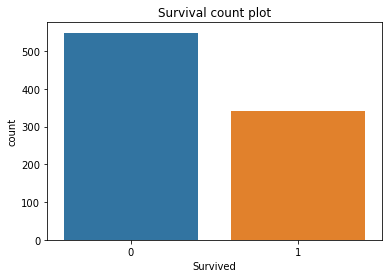

In [22]:
sns.countplot(titanic_ds["Survived"])
plt.title("Survival count plot")

Sirvival count is less than number prople lost their lives

In [23]:
titanic_ds.groupby(["Pclass","Sex","Survived"])["Survived"].count()

Pclass  Sex     Survived
1       female  0             3
                1            91
        male    0            77
                1            45
2       female  0             6
                1            70
        male    0            91
                1            17
3       female  0            72
                1            72
        male    0           300
                1            47
Name: Survived, dtype: int64

Survival ratio for female is more than male. pclass 3rd's male dead ratio is more than other category

In [24]:
titanic_ds.groupby("Pclass").mean()# Pclass column wise average of other columns

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,461.597222,0.629630,37.073708,0.416667,0.356481,86.102713
2,445.956522,0.472826,29.897833,0.402174,0.380435,21.335950
3,439.154786,0.242363,26.447422,0.615071,0.393075,13.786960


class 3rd passengers' were younger than other two class categories

In [25]:
titanic_ds.groupby("Survived").mean()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
Survived,,,,,,
0,447.016393,2.531876,30.562012,0.553734,0.329690,23.184869
1,444.368421,1.950292,28.410122,0.473684,0.464912,48.435395


# Univariate analysis

In [27]:
def plot_hist(val):
    plt.figure(figsize  =(5,5))
    sns.distplot(titanic_ds[val],bins = 20)
    plt.xlabel("Variable ")
    plt.ylabel("Frequency")
    plt.title(f"{val} distribution with hist")

In [28]:
n_col = ['Age', 'Fare']

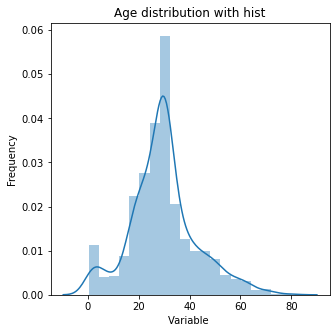

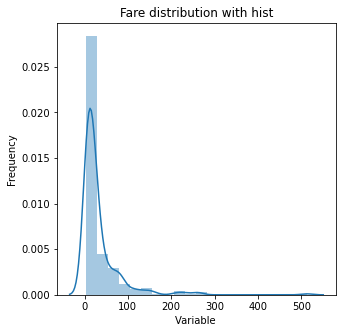

In [29]:
for i in n_col:
    plot_hist(i)

Age and Fare both are right skewed distributon

<AxesSubplot:xlabel='Age'>

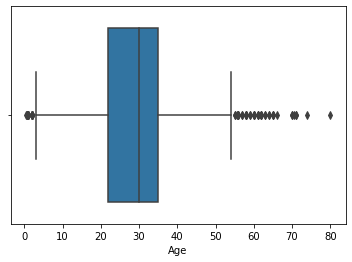

In [31]:

sns.boxplot(titanic_ds["Age"])

<AxesSubplot:xlabel='Fare'>

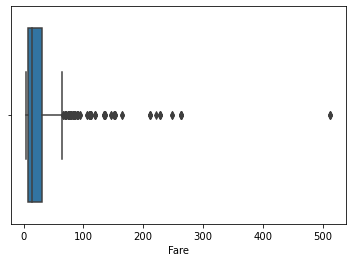

In [32]:
sns.boxplot(titanic_ds["Fare"])


# Bivariate analysis

<AxesSubplot:xlabel='Age', ylabel='Fare'>

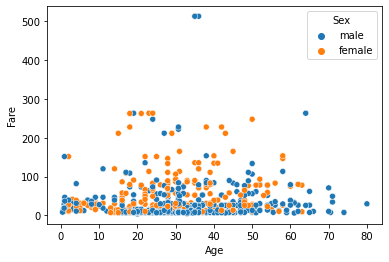

In [33]:
sns.scatterplot(x = "Age",y = "Fare", data = titanic_ds, hue = "Sex")


who paid above 100 pound maximum people survived

# Feature Transform or labeling

In [35]:
# There are coluns which needs labeling here are those name "Sex" and "emnarked"

# replacing male into 1 and female in 0
titanic_ds["Sex"]  = titanic_ds["Sex"].replace({"male": 1,"female":0})
    
# replacing C into 0 and Q into 1 and S into 2
titanic_ds["Embarked"]  = titanic_ds["Embarked"].replace({"C": 0,"Q":1,"S":2})

In [36]:
# Column sibsp and parch are carrying the same information about the family. so we can merge them into 1 columns

titanic_ds["Family_member"] =titanic_ds["SibSp"] +titanic_ds["Parch"]  

In [37]:
titanic_ds.drop(columns = ["SibSp","Parch"],axis = 1, inplace = True)


In [38]:
titanic_ds.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family_member
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,A/5 21171,7.2500,NaN,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,PC 17599,71.2833,C85,0,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,STON/O2. 3101282,7.9250,NaN,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,113803,53.1000,C123,2,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,373450,8.0500,NaN,2,0


Observation
have transformed Sex and Embarked columns into nominal category. SibSp and Parch columns are having same information about the family thus we have club both of them into one.
We have name, ticket and cabin columns which also needs deleting, name is string and ticket is mix of string and number. encoding will no make any sense

In [39]:
titanic_ds.drop(columns = ["Name","Ticket","Cabin"], axis = 1, inplace = True)


In [40]:
titanic_ds.head(10)


,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Family_member
0,1,0,3,1,22.000000,7.2500,2,1
1,2,1,1,0,38.000000,71.2833,0,1
2,3,1,3,0,26.000000,7.9250,2,0
3,4,1,1,0,35.000000,53.1000,2,1
4,5,0,3,1,35.000000,8.0500,2,0
5,6,0,3,1,30.726645,8.4583,1,0
6,7,0,1,1,54.000000,51.8625,2,0
7,8,0,3,1,2.000000,21.0750,2,4
8,9,1,3,0,27.000000,11.1333,2,2
9,10,1,2,0,14.000000,30.0708,0,1


# Modeling


In [41]:
# seprate data into train and test and importing some important library

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble  import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report

In [42]:
X = titanic_ds.drop(columns = "Survived", axis = 1)
y = titanic_ds["Survived"]


sc = StandardScaler()

X = sc.fit_transform(X) # Applying standard scaler for standarized the X values

# Spliting into train & test 

X_train,X_test, y_train,y_test = train_test_split(X,y, test_size = .20, random_state =150)

models = [LogisticRegression(),DecisionTreeClassifier(),RandomForestClassifier(),AdaBoostClassifier(),KNeighborsClassifier(),SVC()]

for model in models:
    model.fit(X_train,y_train)
    print("Train score",model.score(X_train,y_train))
    pred = model.predict(X_test)
    print("Test score",model.score(X_test,y_test))
    print("ROC_Score", model,roc_auc_score(pred,y_test))
    print("confusion_matrix", model,"\n",confusion_matrix(pred,y_test))
    print("classification_report ", model,"\n",classification_report(pred,y_test))

Train score 0.7851123595505618
Test score 0.8659217877094972
ROC_Score LogisticRegression() 0.8639162561576355
confusion_matrix LogisticRegression() 
 [[101  15]
 [  9  54]]
classification_report  LogisticRegression() 
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       116
           1       0.78      0.86      0.82        63

    accuracy                           0.87       179
   macro avg       0.85      0.86      0.86       179
weighted avg       0.87      0.87      0.87       179

Train score 1.0
Test score 0.7653631284916201
ROC_Score DecisionTreeClassifier() 0.7536945812807883
confusion_matrix DecisionTreeClassifier() 
 [[92 24]
 [18 45]]
classification_report  DecisionTreeClassifier() 
               precision    recall  f1-score   support

           0       0.84      0.79      0.81       116
           1       0.65      0.71      0.68        63

    accuracy                           0.77       179
   macro avg       0.7

Randomforest, Adaboost and Logisticregresion are producing good auc score along with good F1 score, so we are taking and selecting the logistic regression algorithm as Final MLA.
will apply Grid searchCV for best parameter finding.

In [44]:
LR = LogisticRegression()

parameter = {"penalty" : ['l1', 'l2', 'elasticnet'],
    "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    "C" : [0.2,0.4,0.6,0.8,1],
    "max_iter":[100,200,300,400]}

grid_cv = GridSearchCV(LR,parameter,cv =5,scoring= "f1")
grid_cv.fit(X_train,y_train)
grid_cv.best_params_

{'C': 0.4, 'max_iter': 200, 'penalty': 'l1', 'solver': 'saga'}

In [45]:
grid_LR = LogisticRegression(C= 0.4, max_iter= 100, penalty ='l1', solver = 'saga')
for i in range(2,10):
    cross_val = cross_val_score(grid_LR,X,y ,cv=i)
print("mean",cross_val.mean(), "STD ", cross_val.std())

mean 0.7946127946127945 STD  0.02935285483865775


# AUG ROC curve

In [46]:
grid_LR = LogisticRegression(C= 0.4, max_iter= 100, penalty ='l1', solver = 'saga')
grid_LR.fit(X,y)

proba = grid_LR.predict_proba(X)[:,1]

from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y,proba)

Text(0, 0.5, 'TPR')

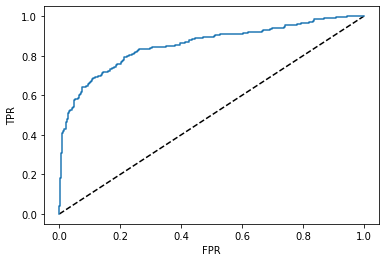

In [47]:
plt.plot([0,1],[0,1],"k--")
plt.plot(fpr,tpr,label = "AUC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")

# The  End